In [37]:
#### import numpy as np
import copy as cp
import matplotlib.pyplot as plt

OS = 0 # 1 = MAC; 0 = PC

COLORS_ALL = ["green","blue","green","gold","orange","orangered","yellow","gold","orange","orangered",
              "yellow","gold","orange","orangered","yellow","gold","orange","orangered","yellow","gold",
              "orange","orangered"]
'''
Data class to traverse files to build up a training set

directory: defines where the dataset lives on your local machine
-- Example : "C:\\Users\\mswhi\\GestureDataset\\DHG2016"
-- NOTE    : Set OS variable to define file system
features: string to define which features of the hand to use.
-- OPTIONS : 'all', 'fingertips', 'fingers_palm', 'wrist_palm'
frames: string to define which frames of the dataset to use
-- OPTIONS : 'all', 'first_last', 'first_middle_last', 'middle_only'
-- OPTIONS : trim = If true, trim to start/stop frames; false = entire motion
NUM_ESSAIS, NUM_SUBJECTS, NUM_GESTURES: Do not change if using the DHG2016 database
'''

class Data:
    def __init__(self, directory, features='all', frames='all', trim = True,
                 NUM_ESSAIS = 5, NUM_SUBJECTS = 20, NUM_GESTURES = 14):
        self.directory = directory
        self.NUM_ESSAIS = NUM_ESSAIS
        self.NUM_SUBJECTS = NUM_SUBJECTS
        self.NUM_GESTURES = NUM_GESTURES
        self.features = features
        self.frames = frames
        self.trim = trim
        self.trim_data = []     # List of start/stop frames per gesture trial
        self.trim_min = 1000
        self.trim_max = 0
        self.concat_X_train = []
        self.concat_y_train = []
        
        # Build the y_train array, assuming X_train is ordered by gesture
        self.y_train = np.zeros(NUM_ESSAIS * NUM_SUBJECTS * NUM_GESTURES)
        for i in range(len(self.y_train)):
            self.y_train[i] = int(i / (NUM_SUBJECTS * NUM_ESSAIS) + 1)
        
        # Traverse through the directory to build training data
        
        if self.trim == True :
            self.set_trim()
            
        self.X_train = self.traverse_data()
        
    # Read in the trim data file. The format is:
    #   gesture #
    #   finger #
    #   subject #
    #   essai # (trial #)
    #   frame of the the effective beginning of the gesture
    #   frame of the the effective end of the gesture
    def set_trim(self):
        if OS == 1:
            trim_filename = self.directory + "/informations_troncage_sequences.txt"
        else:
            trim_filename = self.directory + "\\informations_troncage_sequences.txt"
        
        trim_file = open(trim_filename, 'r')
        
        # The trim database has some out-of-order elements so after reading it in, re-sort to fix it.
        for line in trim_file:
            numbers = [int(x) for x in line.split(' ')]
            self.trim_data.append(numbers)
        self.trim_data = sorted(sorted(sorted(sorted(self.trim_data, key = lambda x : x[3]), key = lambda x : x[1]),key = lambda x : x[2]), key = lambda x : x[0])
    
        # Find the max and min lengths in case padding is needed
        for line in self.trim_data:
            self.trim_min = min(self.trim_min,line[5]-line[4]+1)
            self.trim_max = max(self.trim_min,line[5]-line[4]+1)
            
    # Traverse to parse each "skeleton_world.txt" file in the directory
    def traverse_data(self):
        
        trials = []
        for gesture_num in range(1, self.NUM_GESTURES + 1):
            for subject_num in range(1, self.NUM_SUBJECTS + 1):
                for essai_num in range(1, self.NUM_ESSAIS + 1):
                    
                    if self.trim == True:
                        index = (gesture_num - 1)* 2 * self.NUM_SUBJECTS * self.NUM_ESSAIS \
                            + (subject_num - 1) * 2 * self.NUM_ESSAIS \
                            + essai_num - 1

                        # a quick self-check on the dataset to make sure we're aligned
                        if (gesture_num != self.trim_data[index][0]) or (subject_num != self.trim_data[index][2]) \
                            or (essai_num != self.trim_data[index][3]) :
                            print("Error in truncage file sync: Gesture: ",gesture_num," Subject: ",subject_num," Trial: ",essai_num,
                             "index: ",index,"trim: ",self.trim_data[index])
                                               
                    else:
                        index = 0
                        
                    if OS == 1:
                        trials.append(self.parse_frames(self.directory + "/gesture_" + 
                                                        str(gesture_num) + "/finger_1/subject_" + str(subject_num) + 
                                                        "/essai_" + str(essai_num) + "/skeleton_world.txt",index))
                    else:
                        trials.append(self.parse_frames(self.directory + "\\gesture_" + 
                                                        str(gesture_num) + "\\finger_1\\subject_" + str(subject_num) + 
                                                        "\\essai_" + str(essai_num) + "\\skeleton_world.txt",index))
        return trials
    
    # Entry point to parse a particular file--filtering based on self.frames and self.features
    def parse_frames(self, filename,index):
        file = open(filename, 'r')
        lines = []
        for line in file:
            lines.append(line)
            
        # If trimming is enabled, trim to the start/stop limits defined in the truncation file
        if self.trim == True:
            lines = lines[self.trim_data[index][4]:self.trim_data[index][5]+1]
        else:
            lines = lines[0:len(lines)]                
        
        # Set the 'frames' dimension based on how the data should be sampled
        if self.frames == 'all':
            num_frames = len(lines)
        elif self.frames == 'first_last':
            num_frames = 2
        elif self.frames == 'first_middle_last':
            num_frames = 3
        elif self.frames == 'middle_only':
            num_frames = 1
        
        # Set the 'features' dimension based on how the data should be sampled
        if self.features == 'all':
            num_features = 22
        elif self.features == 'fingertips':
            num_features = 5
        elif self.features == 'wrist_palm':
            num_features = 3
        elif self.features == 'fingers_palm':
            num_features = 6
            
        frames = []
        
        # Add frames in a particular way, depending on the filtering strategy
        if self.frames == 'all':
            for i in range(len(lines)):
                line = lines[i]
                frames.append(self.parse_frame(line))
                
        elif self.frames == 'first_last':
            frames.append(self.parse_frame(lines[0]))
            frames.append(self.parse_frame(lines[len(lines) - 1]))
            
        elif self.frames == 'first_middle_last':
            frames.append(self.parse_frame(lines[0]))
            frames.append(self.parse_frame(lines[int(len(lines) / 2)]))
            frames.append(self.parse_frame(lines[len(lines) - 1]))
            
        elif self.frames == 'middle_only':
            frames.append(self.parse_frame(lines[int(len(lines) / 2)]))
            
        return frames

    # Parse an individual frame (line in a file)
    def parse_frame(self, line):
        numbers = line.split(' ')
        full_frame = np.zeros((22,3))
        
        for j in range(len(numbers)):
            full_frame[int(j / 3)][j % 3] = numbers[j]
        
        # Add features on the hand in a particular way, depending on the filtering strategy
        
        frame = []
        if self.features == 'all':
            for i in range (0,22):
                frame.append([full_frame[i],COLORS_ALL[i]])
            return frame
        
        elif self.features == 'fingertips':
            frame.append([full_frame[5],COLORS_ALL[5]])
            frame.append([full_frame[9],COLORS_ALL[9]])
            frame.append([full_frame[13],COLORS_ALL[13]])
            frame.append([full_frame[17],COLORS_ALL[17]])
            frame.append([full_frame[21],COLORS_ALL[21]])
            return frame
        
        elif self.features == 'wrist_palm':
            frame.append([full_frame[0],COLORS_ALL[0]])
            frame.append([full_frame[1],COLORS_ALL[1]])
            frame.append([full_frame[2],COLORS_ALL[2]])
            return frame

        elif self.features == 'fingers_palm':
            frame.append([full_frame[1],COLORS_ALL[1]])
            frame.append([full_frame[5],COLORS_ALL[5]])
            frame.append([full_frame[9],COLORS_ALL[9]])
            frame.append([full_frame[13],COLORS_ALL[13]])
            frame.append([full_frame[17],COLORS_ALL[17]])
            frame.append([full_frame[21],COLORS_ALL[21]])
            return frame


In [38]:
import math
import random as rnd

# When instantiated, this class will take the data of class Data and perform the modifications defined in 
# the pass parameter mods. The mods are performed in a defined sequence. A step in the sequence may be 
# skipped by not passing in a request for that mod but the order of the mods cannot be changed (e.g translate
# will always occur before scale.

# See the individual mods for a description of their algorithm.
# Inputs:
#   data: a Data class structure
#   mods: a string containing the mods to perform in the order that the mods should be performed
#
class Data_Mods:
    def __init__(self,data,mods):
        
        self.raw_X_train = data.X_train
        self.raw_y_train = data.y_train
        
        self.mod_X_train = cp.deepcopy(data.X_train)   # A working array to hold the data as it's modified
        self.mod_y_train = cp.deepcopy(data.y_train)

        self.X_train = cp.deepcopy(data.X_train)
        self.y_train = cp.deepcopy(data.y_train)
        
        self.X_test = []
        self.y_test = []
        
        # Take apart the mods string here one string at a time and call the associated function
        switcher = {
                    "center":    self.center,
                    "translate": self.translate,
                    "scale":     self.scale,
                    "angles":    self.angles,
                    "delta":     self.delta
                    }

        debug = False

        if debug == True:
            printFrame(self.raw_X_train[0][0])
            display(self.raw_X_train[0]) 

        # A python switch statement...
        for key in mods.split(" "):
            print("Performing ",key," modification")
            func = switcher.get(key, "nothing")
            if func == "nothing":
                print("key: ",key," is invalid")
            else:
                func()
                if debug == True:
                    printFrame(self.mod_X_train[0][0])
                    display(self.mod_X_train[0]) 

    def minMax(self,val,lmin,lmax,lsum):
        
        if val < lmin:
            lmin = val
        elif val > lmax:
            lmax = val

        lsum += val

        return(lmin,lmax,lsum)
            
    # This function collects various stats about the data frame passed in
    def stats(self,frame):
        x_min  = 10000
        x_max  = -10000
        x_mean = 0
        
        y_min = 10000
        y_max = -10000
        y_mean = 0
        
        z_min = 10000
        z_max = -10000
        z_mean = 0
            
        joint_cnt = 0
        for joint in frame:
            [x_min,x_max,x_mean] = self.minMax(joint[0][0],x_min,x_max,x_mean)
            [y_min,y_max,y_mean] = self.minMax(joint[0][1],y_min,y_max,y_mean)
            [z_min,z_max,z_mean] = self.minMax(joint[0][2],z_min,z_max,z_mean)
            
            joint_cnt += 1
        
        x_mean = x_mean/joint_cnt
        y_mean = y_mean/joint_cnt
        z_mean = z_mean/joint_cnt
        
        return (x_min,x_mean,x_max,y_min,y_mean,y_max,z_min,z_mean,z_max)
        
    # This function translates all the gestures such that the wrist (point 0)
    # resides at 0.5, 0.5, 0.5 to remove variation between trials and subjects
    # 
    # The input is the sequence of frames for a gesture where the array dimensions are:
    #     [trial #][frame #][hand joint #][position array = 0, color = 1][x = 0, y = 1, z = 2]
    def center(self):
        
        # find the global mins for each axis
        gx_min = 1000
        gy_min = 1000
        gz_min = 1000
        for trial in self.mod_X_train:
            for frame in trial:
                [x_min,x_mean,x_max,y_min,y_mean,y_max,z_min,z_mean,z_max] = self.stats(frame)
                if x_min < gx_min:
                    gx_min = x_min

                if y_min < gy_min:
                    gy_min = y_min
                    
                if z_min < gz_min:
                    gz_min = z_min
         
        # Center all the frames up by the global min or 1.0 which ever is greater so there 
        # are no negative coordinates
        
        offset_x = 1.0
        offset_y = 1.0
        offset_z = 1.0
        
        if gx_min < 0:
            offset_x += abs(gx_min)
        if gy_min < 0:
            offset_y += abs(gy_min)
        if gz_min < 0:
            offset_z += + abs(gz_min)
            
#        print(gx_min,gy_min,gz_min)
        
        for trial in self.mod_X_train:
            
            # Calculate how far to move this trial to be centered on the common point
            cx = offset_x - trial[0][0][0][0]
            cy = offset_y - trial[0][0][0][1]
            cz = offset_z - trial[0][0][0][2]
            
            # Move all the data points in each frame for this trial by that common offset
            for frame in trial:
                for joint in frame:
                    joint[0][0] += cx
                    joint[0][1] += cy
                    joint[0][2] += cz
             
    # Perform a Procustes translation
    # 
    # Modifies the mod data frames where all x, y, z coordinates are divided by the x mean, y mean, z mean respectively
    def translate(self):
        
        for trial in self.mod_X_train:
            for frame in trial:
                [x_min,x_mean,x_max,y_min,y_mean,y_max,z_min,z_mean,z_max] = self.stats(frame)
                for joint in frame:
                    joint[0][0] = joint[0][0]/x_mean
                    joint[0][1] = joint[0][1]/y_mean
                    joint[0][2] = joint[0][2]/z_mean                

    def scale(self):
        
        for trial in self.mod_X_train:
            for frame in trial:
                lsum = 0
                for joint in frame:
                    lsum += joint[0][0]**2 + joint[0][1]**2 + joint[0][2]**2
                lscale = math.sqrt(lsum/len(frame))
             
                for joint in frame:
                    joint[0][0] = joint[0][0]/lscale
                    joint[0][1] = joint[0][1]/lscale
                    joint[0][2] = joint[0][2]/lscale                
  
    # This function coverts from X, Y, Z coordinates to X-Y Angle, X-Z Angle, Vector Length.
    # The angles returned are in radians.
    #
    # Output:
    #    Joint[0][0] = X-Y angle
    #    Joint[0][1] = X-Z angle
    #    Joint[0][2] = Vector length
    
    def angles(self):
        
        for trial in self.mod_X_train:
            for frame in trial:
                for joint in frame:
                    x = joint[0][0]
                    y = joint[0][1]
                    z = joint[0][2]
                    joint[0][0] = math.atan(y/x)
                    joint[0][1] = math.atan(z/x)
                    joint[0][2] = math.sqrt(x**2 + y**2 + z**2)
      
    # This function converts a trial from a series of frames containing absolute X, Y, Z 
    # locations to a delta between each frame. There are Frame - 1 deltas here so the last element
    # of the array holding the modified data gets truncated by one.
    #
    # Output:
    #    Joint[0][0] = X(t-1) - X(t)
    #    Joint[0][1] = Y(t-1) - Y(t)
    #    Joint[0][2] = Z(t-1) - Z(t)

    def delta(self):
        
        for trial in self.mod_X_train:
            for frame in range(len(trial)-1):
                for joint in range(len(trial[frame])):
                    trial[frame][joint][0][0] = trial[frame][joint][0][0] - trial[frame+1][joint][0][0]
                    trial[frame][joint][0][1] = trial[frame][joint][0][1] - trial[frame+1][joint][0][1]
                    trial[frame][joint][0][2] = trial[frame][joint][0][2] - trial[frame+1][joint][0][2]

            trial.pop(len(trial)-1)

    # This function creates vectors out of the data. 
    #   data_set - "raw" = use the original, unmodified data
    #              "modified" = use the modified data 
    #
    #   concat - "by_frame" = Each trial, each frame will be individually concatenated into a vector (frame 
    #                         vectors) and the trial will have the dimensionality of the number of frames in 
    #                         that trial. The trial is now a frames dimensional list of frame vectors 
    #            "all" = For each trial, all frames for a that trial are concatenated together in order of time stamp
    def concatenate(self,data_set="raw",concat="by_frame"):
        if data_set == 'modified':
            data = self.mod_X_train
        else:
            data = self.raw_X_train
            
        gest_cnt = 0
        concat_X_train = []
        concat_y_train = []

        for trial in data:
            if concat == "by_frame":
                tmp_frame = []
                for frame in trial:
                    tmp_axis = []
                    for joint in frame:
                        for axis in joint[0]:
                            tmp_axis.append(axis)
                    tmp_frame.append(tmp_axis)
                concat_X_train.append(np.array(tmp_frame))
                concat_y_train.append(self.raw_y_train[gest_cnt])
                gest_cnt += 1
            else: #"all"
                tmp_work = []
                for frame in trial:
                    for joint in frame:
                        for axis in joint[0]:
                            tmp_work.append(axis)
                concat_X_train.append(np.array(tmp_work))
                concat_y_train.append(self.raw_y_train[gest_cnt])
                gest_cnt += 1

        return (np.array(concat_X_train),np.array(concat_y_train))

    # This function does a basic randomization. It takes the dataset passed in
    # and sets X_train, y_train to a randomized version of it
    def shuffle(self,data_x,data_y):
        random_indices = rnd.sample(range(len(data_x)), len(data_x))
        new_i = 0
        for i in random_indices:
            self.X_train[new_i] = data_x[i]
            self.y_train[new_i] = data_y[i]
            new_i += 1
            
        self.X_train = np.array(self.X_train)
        self.y_train = np.array(self.y_train)
        
    # This function sets aside pct of the data passed in for the training set and the 
    # remaining 1-pct as the test set
    #
    # pct     - percent split between training and test
    # gesture - -1 if all gestures included, >= 0 defines gesture that will have y = 1
    #           all other gestures will be -1
    #
    # Note: This function needs to be called after shuffle
    def split_data(self,ratio):
        X_data = cp.deepcopy(self.X_train)
        y_data = cp.deepcopy(self.y_train)

        train_length = int(ratio * self.X_train.shape[0])
        self.X_test  = np.array(X_data[train_length:])
        self.X_train = np.array(X_data[:train_length])
        
        self.y_test  = np.array(y_data[train_length:])
        self.y_train = np.array(y_data[:train_length])


In [4]:
#myPath = "/home/jovyan/data"
myPath = "C:\\Users\\mswhi\\GestureDataset\\DHG2016"

data = Data(myPath, features = 'all', frames='all',trim=True) # Include all data points, all frames
#data = Data(myPath, features = 'fingertips', frames='first_middle_last') # fingertips only, using 3 frames at beginning middle, end of the gesture
#data = Data(myPath, features = 'wrist_palm', frames='middle_only') # wrist and palm points using only the middle frame

#display(data.X_train[0]) # plot (in 2D the first gesture in the training set)


NameError: name 'np' is not defined

Set up an SVM Kernel

In [39]:
# For testing purposes only: display each frame of the trial passed in
def display(trial):
            
    f_cnt = 0
    for frame in trial:
        x_vals = []
        y_vals = []
        clr = []
        
        for feature in frame:
            x_vals.append(feature[0][0])
            y_vals.append(feature[0][1])
            clr.append(feature[1])
            
        plt.scatter(x_vals, y_vals,c=clr)
        plt.title("Frame " + str(f_cnt))
        plt.show()
        f_cnt += 1

# Another helper function to print out a frame
def printFrame(frame):

    print("   X      Y     Z    Color")
    for feature in frame:
        print("{0:6.3f} {1:6.3f} {2:6.3f} {3}".format(feature[0][0],feature[0][1],feature[0][2],feature[1]))
            

In [40]:
import numpy as np
from numpy import linalg as LA
MAX_ITER = 5

def linear_kernel(x1, x2):
    return (1 + np.dot(x1, x2))
    
def polynomial_kernel(x1, x2, p = 3):
    return (1 + np.dot(x1, x2)) ** p
    
def gaussian_kernel(x1, x2, sigma = 0.5):
    return np.exp(-LA.norm(x1-x2)**2 / (2 * (sigma ** 2)))

In [6]:
class KernelPerceptron:
    def __init__(self, kernel = linear_kernel, Niter = 1):
        
        self.kernel = kernel
        self.Niter = Niter
        self.support_vector_x = None
        self.support_vector_y = None
        self.alpha = []
        self.bias = []
        
    def fit(self, X, y):
        n_samples = X.shape[0]
        self.alpha = np.zeros(n_samples, dtype=np.float64)
        self.bias = np.zeros(n_samples, dtype=np.float64)

        for iter in range(self.Niter):
            for i in range(n_samples):
                sum = 0
                for j in range(n_samples): 
                    sum += self.alpha[j]*y[j]*(self.kernel(X[j],X[i]))
                if sum * y[i] <= 0:
                    self.alpha[i] += 1
                   
      # Support vectors
        sv = self.alpha > 1e-5 # ignore really small alphas - probably rounding issues
        self.alpha = self.alpha[sv]
        self.bias = self.bias[sv]
        self.support_vector_x = X[sv]
        self.support_vector_y = y[sv]
        print(np.count_nonzero(sv)," support vectors.")    
    
    def predict(self, X):
        n_samples = X.shape[0]
        y_predict = np.zeros(len(X))
        for i in range(len(X)):
            sum = 0
            for j in range(len(self.alpha)):
                sum += self.alpha[j] * self.support_vector_y[j] * self.kernel(X[i], self.support_vector_x[j]+self.bias[j])
            y_predict[i] = sum
        return np.sign(y_predict)



In [41]:
def bootstrap(X_train, y_train, ratio):
    """
    Args:
        n (int): total size of the training data
        X_train (ndarray): [n_samples x n_features] ndarray of training data   
        y_train (ndarray): [n_samples] ndarray of data 
    """
    selected_indices = np.random.randint(y_train.shape[0], size=int(ratio * y_train.shape[0]))
    return [X_train[i] for i in selected_indices], [y_train[i] for i in selected_indices]
def voting(y_hats):
    counts = dict()
    for i in y_hats:
        counts[int(i)] = counts.get(int(i), 0) + 1
    class_num, count = max((class_num, count) for class_num, count in counts.items())
    return class_num

In [42]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(10,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [9]:
from sklearn import svm

#myPath = "/home/jovyan/data"
myPath = "C:\\Users\\mswhi\\GestureDataset\\DHG2016"

data = Data(myPath, features = 'fingers_palm', frames='first_middle_last',trim=False) # Include all data points, all frames
mod_data = Data_Mods(data,"center")
#mod_data = Data_Mods(data,"center translate scale angles")
#mod_data = Data_Mods(data,"center translated scaled delta")

np.set_printoptions(precision=3)

[X_data,y_data] = mod_data.concatenate('raw','all')
print("Raw, single vector per trial")
print(X_data.shape)
print(X_data[0])
print(y_data[0])
print("\n")

[X_data,y_data] = mod_data.concatenate('modified','all')
print("Modified, single vector per trial")
print(X_data.shape)
print(X_data[0])
print(y_data[0])
print("\n")

[X_data,y_data] = mod_data.concatenate('modified','by_frame')
print("Modified, vector for each frame of trial")
print(X_data.shape)
print(X_data[0])
print(y_data[0])
print("\n")

mid_frame_X_train = np.array(list(zip(*X_data))[1]) # Get just the middle frames of a first_middle_last data pull
                                                    # NOTE: only works if concatenate is by_frame
print("Looking at just the middle frames for the first three trials")
print(mid_frame_X_train.shape)
print(mid_frame_X_train[0:3])
print("\n")

[X_data,y_data] = mod_data.concatenate('modified','all')
mod_data.shuffle(X_data,y_data)
print("pre-split X_train size:",mod_data.X_train.shape)
print("pre-split y_train size:",mod_data.y_train.shape)
mod_data.split_data(0.8)
print("pre-split X_train size:",mod_data.X_train.shape)
print("pre-split y_train size:",mod_data.y_train.shape)

print("pre-split X_test size:",mod_data.X_test.shape)
print("pre-split y_test size:",mod_data.y_test.shape)

clf = svm.SVC(gamma=0.01, decision_function_shape='ovo')
clf_stat = clf.fit(mod_data.X_train, mod_data.y_train)  
print(clf_stat)

clf.decision_function_shape = "ovr"
y_hat = clf.decision_function(mod_data.X_test)
print(y_hat.shape)
print(y_hat)
print(y_hat[0])
print(mod_data.y_test)

err = 0
errs = []
for i in range(len(mod_data.y_test)):
    guess = np.argmax(y_hat[i])
    if guess != mod_data.y_test[i]:
        print(i,guess,mod_data.y_test[i])
        err += 1
        errs.append(i)
        
print("Errors: {0:4d} Accuracy: {1:4.2f}%".format(err,(1-err/len(mod_data.y_test))*100))
print("Misclassified: ",errs)



KeyboardInterrupt: 

Performing  center  modification
Performing  delta  modification
Normalized confusion matrix


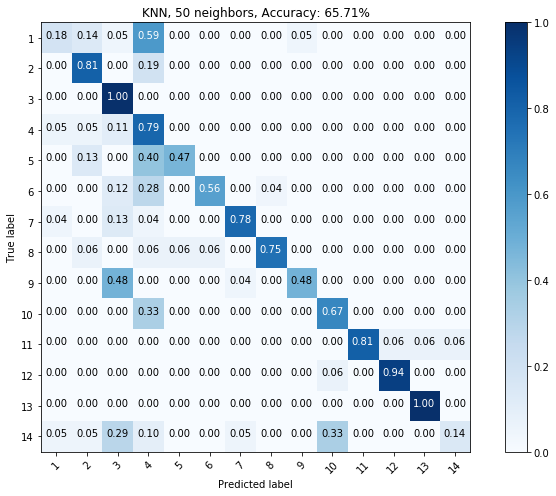

In [46]:
from sklearn import neighbors

myPath = "C:\\Users\\mswhi\\GestureDataset\\DHG2016"

data = Data(myPath, features = 'all', frames='first_middle_last',trim=True) # Include all data points, all frames
#mod_data = Data_Mods(data,"center")
mod_data = Data_Mods(data,"center delta")
#mod_data = Data_Mods(data,"center translated scaled delta")

np.set_printoptions(precision=3)

[X_data,y_data] = mod_data.concatenate('modified','all')
mod_data.shuffle(X_data,y_data)
mod_data.split_data(0.8)
'''
clf = svm.SVC(gamma=0.01, decision_function_shape='ovo')
clf_stat = clf.fit(mod_data.X_train, mod_data.y_train)  

clf.decision_function_shape = "ovr"
y_hat = clf.decision_function(mod_data.X_test)
'''
num_neighbors = 50
knn = neighbors.KNeighborsClassifier(n_neighbors=num_neighbors)
knn_stat = knn.fit(mod_data.X_train, mod_data.y_train)
guesses = knn.predict(mod_data.X_test)
err = 0
errs = []
# Confusion matrix where rows are true labels, columns are predictions
confusion_matrix = np.zeros(shape=(14,14))
for i in range(len(mod_data.y_test)):
    #print(y_hat[i])
    guess = guesses[i]
    confusion_matrix[int(mod_data.y_test[i]) - 1][int(guess) - 1] += 1
    if int(guess) != int(mod_data.y_test[i]):
        err += 1
        errs.append(i)
        
plot_title = "KNN, " + str(num_neighbors) + " neighbors, Accuracy: {1:4.2f}%".format(err,(1-err/len(mod_data.y_test))*100)
plot_confusion_matrix(confusion_matrix, range(1,15), normalize=True, title=plot_title)


Performing  angles  modification
Normalized confusion matrix


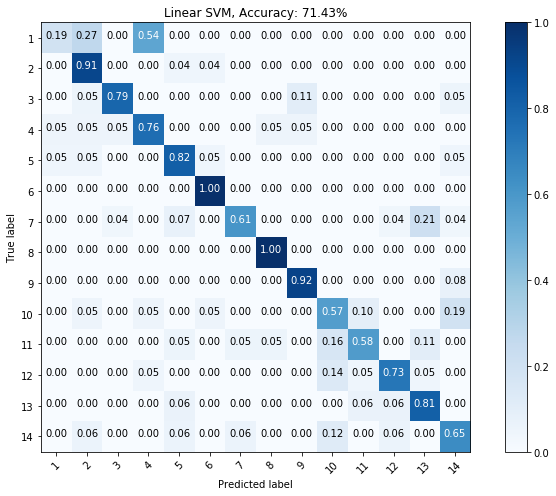

In [49]:
myPath = "C:\\Users\\mswhi\\GestureDataset\\DHG2016"

data = Data(myPath, features = 'all', frames='first_last',trim=True) # Include all data points, all frames
#mod_data = Data_Mods(data,"center")
mod_data = Data_Mods(data,"angles")
#mod_data = Data_Mods(data,"center translated scaled delta")

np.set_printoptions(precision=3)

[X_data,y_data] = mod_data.concatenate('modified','all')
mod_data.shuffle(X_data,y_data)
mod_data.split_data(0.8)

classifiers = []
num_classifiers = 1
ratio = 1
for i in range(num_classifiers):
    X_train, y_train = bootstrap(mod_data.X_train, mod_data.y_train, 1)
    classifier = svm.LinearSVC()
    classifier.fit(X_train, y_train)  
    classifiers.append(classifier)

y_hat_matrix = np.zeros(shape=(num_classifiers,len(mod_data.y_test)))
for i in range(num_classifiers):
    test_y_output = classifiers[i].decision_function(mod_data.X_test)
    for j in range(len(test_y_output)):
        y_hat = np.argmax(test_y_output[j])
        y_hat_matrix[i][j] = y_hat


err = 0
errs = []

# Confusion matrix where rows are true labels, columns are predictions
confusion_matrix = np.zeros(shape=(14,14))
for i in range(len(mod_data.y_test)):
    #print(y_hat[i])
    guess = voting(y_hat_matrix[:,i]) + 1
    confusion_matrix[int(mod_data.y_test[i]) - 1][int(guess) - 1] += 1
    if guess != mod_data.y_test[i]:
        err += 1
        errs.append(i)
    
plot_title = "Linear SVM, Accuracy: {1:4.2f}%".format(err,(1-err/len(mod_data.y_test))*100)
plot_confusion_matrix(confusion_matrix, range(1,15), normalize=True, title=plot_title)


Performing  scale  modification
Performing  angles  modification
Normalized confusion matrix


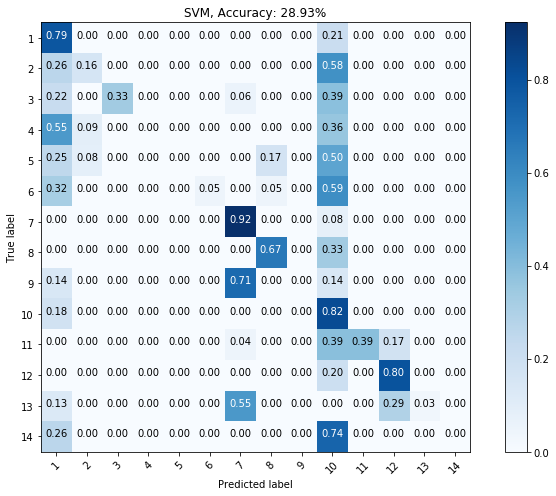

In [50]:
myPath = "C:\\Users\\mswhi\\GestureDataset\\DHG2016"

data = Data(myPath, features = 'fingertips', frames='first_middle_last',trim=True) # Include all data points, all frames
#mod_data = Data_Mods(data,"center")
mod_data = Data_Mods(data,"scale angles")
#mod_data = Data_Mods(data,"center translated scaled delta")

np.set_printoptions(precision=3)

[X_data,y_data] = mod_data.concatenate('modified','all')
mod_data.shuffle(X_data,y_data)
mod_data.split_data(0.8)

clf = svm.SVC()
clf_stat = clf.fit(mod_data.X_train, mod_data.y_train)  

y_hat = clf.decision_function(mod_data.X_test)

err = 0
errs = []

# Confusion matrix where rows are true labels, columns are predictions
confusion_matrix = np.zeros(shape=(14,14))
for i in range(len(mod_data.y_test)):
    #print(y_hat[i])
    guess = np.argmax(y_hat[i]) + 1
    confusion_matrix[int(mod_data.y_test[i]) - 1][int(guess) - 1] += 1
    if guess != mod_data.y_test[i]:
        err += 1
        errs.append(i)
    
plot_title = "SVM, Accuracy: {1:4.2f}%".format(err,(1-err/len(mod_data.y_test))*100)
plot_confusion_matrix(confusion_matrix, range(1,15), normalize=True, title=plot_title)